In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import Bio.PDB.Polypeptide as pp
from os.path import join
import os
from matplotlib import cm

In [2]:
sns.set_style('white')

In [3]:
AA = list(pp.aa1)

In [4]:
DATA = '../data/'

In [5]:
## Subi los datos a github 
DATA = 'data/'

In [6]:
HEIGHT = 3

In [7]:
proteins = ['1be9', '1d5r', '1nd4', '3dqw', '4bz3']
protein_names = ['PSD95', 'PTEN', 'APH(3\')II', 'Src CD', 'VIM-2']
get_name = dict(zip(proteins, protein_names))

In [8]:
data_path = join(DATA, 'structure')
thresholds = [round(i, 1) for i in np.linspace(3, 10, 71)]
sample_thresholds = [round(i, 1) for i in np.linspace(3, 10, 8)]
measures = ['nodes', 'edges', 'weight', 'distance']

In [9]:
functional_data = dict()
for protein in proteins:
    csv_file = join(DATA, f'functional_{protein}.csv')
    functional_data[protein] = pd.read_csv(csv_file, index_col=0, header=0)

In [10]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

In [11]:
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

In [12]:
def ReadNetworkCSV(protein, threshold, measure):
    """Return DataFrame from corresponding CSV. If protein has multiple identical chains, return average value for 
    each position amongst all chains."""
    file = os.path.join(join(DATA, 'structure'), f"{protein}/{protein}_{threshold}_{measure}.csv")
    network_df = pd.read_csv(file, header=0)
    network_df.index = AA
    # Get chains from columns
    column_names = list(network_df.columns)
    chains = list(set([position[1] for position in column_names]))
    # Get positions without chain distinction from functional files
    positions = list(functional_data[protein].columns)
    average = pd.DataFrame(index=AA, columns=positions, dtype=np.float64)
    # Save data for position over chains in list, write average into df
    for position in positions:
        for aa in AA:
            values = []
            for chain in chains:
                check = position[0]+chain+position[1:]
                if check in network_df.columns:
                    values.append(network_df.at[aa, check])
            if values:
                average_value = sum(values)/len(values)
                average.at[aa, position] = average_value
    return average

In [13]:
def Standardize(protein, threshold, measure):
    """Return standardized values from network data. Make 0's into NaN. """
    network_df = ReadNetworkCSV(protein, threshold, measure)
    for position in network_df.columns:
        for aa in network_df.index:
            if position[0] == aa:
                network_df.at[aa, position] = np.nan
    data_array = network_df.to_numpy()
    data_mean = np.nanmean(network_df, dtype=np.float64)
    data_std = np.nanstd(network_df, dtype=np.float64)
    network_df = network_df.apply(lambda x:(x-data_mean)/data_std)
    return network_df 

In [35]:
def PlotHeatmap(dataframe, save_as=None, title=None, vmin=None, vmax=None, center=0, reverse=False):
    """Plot heatmap of dataframe values.
    
    Parameters:
        dataframe: data to plot
        save_as: name of file to save. If None, image is not saved
        vmin, vmax: min and max values for colorscale
    """
    # Set missing values gray 
    sns.set(rc={'axes.facecolor':'94A3A8'})
    # Set size to match dataframe dimensions
    w = len(dataframe.columns)
    h = len(dataframe.index)
    ratio = w//h
    plt.figure(figsize=(HEIGHT*ratio,HEIGHT))
    cmap = 'RdBu' if reverse else 'RdBu_r'
    heatmap = sns.heatmap(dataframe, cmap=cmap, center=center, cbar=False, square=True, xticklabels=False, 
                          vmin=vmin, vmax=vmax)
    
    if title:
        ax = plt.gca()
        ax.set_title(title)
    if save_as:
        fig = heatmap.get_figure()
        fig.savefig(f'{save_as}.png', dpi=300, bbox_inches='tight')
    return heatmap

In [15]:
def GetNetworkExtremes(protein, mincount, measure_cutoffs, thresh=9.0):
    """ Return set with positions that pass measure sd cutoffs for at least mincount measures. """
    network_extremes_list = []
    for i,measure in enumerate(measures): 
        threshold = 3.8 if measure == 'distance' else thresh
        network_df = Standardize(protein, threshold, measure)
        if measure_cutoffs[i] > 0:
            extremes = network_df.columns[(network_df > measure_cutoffs[i]).any()].tolist()
        else:
            extremes = network_df.columns[(network_df < measure_cutoffs[i]).any()].tolist()
        network_extremes_list.extend(extremes)

    counter = Counter(network_extremes_list)
    positions = list(set(network_extremes_list))
    return set([pos for pos in positions if counter[pos] >= mincount])

In [16]:
def GraphLossPredictions(functional_percentage, network_mincount, measure_cutoffs=[1,1,1,1], thresh=9.0,
                        proteins=proteins):
    '''Graph positions and mean functional value, marking predictions for loss of function and where functional 
    percentage separates values.'''
    labels1 = ['PSD95', 'PTEN', 'APH(3\')II', 'Src CD', 'VIM-2']
    sns.set_style('white')
    w = len(func.columns)
    h = len(func.index)
    ratio = w//h

    fig, axes = plt.subplots(nrows=1, ncols=len(proteins), figsize=(HEIGHT * ratio, HEIGHT))
    
    # X and Y labels for plot
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel('Positions')
    
    # get colors to match RdBu cmap
    rdbu = cm.get_cmap('RdBu', 24)
    red = rdbu(5)
    blue = rdbu(19)
    lightblue = rdbu(15)

    for i, protein in enumerate(proteins):
        ax = axes[i] if len(proteins)!=1 else axes
        
        if i==0:
            ax.set_ylabel('Mean Functional Value', position=(0, 0.5))
             
        mean = functional_data[protein].mean()
        positions = functional_data[protein].columns
        n = len(positions)
        predictions = GetNetworkExtremes(protein, network_mincount, measure_cutoffs, thresh)
        
        # values to plot, depending on whether they are predicted or not
        predicted_values = [mean[pos] for pos in positions if pos in predictions]
        predicted_indices = [i for i,pos in enumerate(positions) if pos in predictions]
        other_values = [mean[pos] for pos in positions if pos not in predictions]
        other_indices = [i for i,pos in enumerate(positions) if pos not in predictions]
        
        ax.plot(other_indices, other_values, color=red, marker='o', markeredgewidth=0.0, linewidth=0,
             label='Positions not predicted')
        ax.plot(predicted_indices, predicted_values, color=blue, marker='o', markeredgewidth=0.0, linewidth=0,
             label='Positions predicted')
        
        # mark functional percentage
        mean_list = list(mean)
        mean_list.sort()
        m = mean_list[int(n*0.4)]

        ax.set_xlim([-1, len(positions)])

        min_y, max_y = mean_list[0], mean_list[-1]
        gap = (max_y-min_y)*0.05
        ax.set_ylim(min_y-gap, max_y+gap)

        ax.set_title(protein_names[-1])
        ax.axhspan(min_y-gap, m, facecolor=lightblue, alpha=0.25)

        # ax.plot([i for i in range(n)], [m for i in range(n)], 
        #                                label=f'Bottom {int(100*functional_percentage)}% of values')

        ax.set_title(get_name[protein])
        
        #handles, labels = ax.get_legend_handles_labels()
        # fig.legend(handles, labels)

    return fig

In [43]:
def GraphGainPredictions(functional_percentage, network_mincount, measure_cutoffs=[1,1,1,1], thresh=9.0, 
                        proteins=proteins):
    '''Graph positions and mean functional value, marking predictions for robust positions and where functional 
    percentage separates values.'''
    labels1 = ['PSD95', 'PTEN', 'APH(3\')II', 'Src CD', 'VIM-2']
    sns.set_style('white')
    w = len(functional_data['1d5r'].columns) ## set size for protein 1d5r (PTEN)
    h = len(functional_data['1d5r'].index)
    ratio = w//h
    
    fig, axes = plt.subplots(nrows=1, ncols=len(proteins), figsize=(HEIGHT * ratio, HEIGHT))
    
    # X and Y labels for plot
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel('Positions')
    
    # get colors to match RdBu cmap
    rdbu = cm.get_cmap('RdBu', 24)
    red = rdbu(5)
    blue = rdbu(19)
    lightblue = rdbu(15)
    
    for i, protein in enumerate(proteins):
        ax = axes[i] if len(proteins)!=1 else axes
        
        if i==0:
            ax.set_ylabel('Mean Functional Value', position=(0, 0.5))
            
        mean = functional_data[protein].mean()
        positions = functional_data[protein].columns
        n = len(positions)
        predictions_loss = GetNetworkExtremes(protein, network_mincount, measure_cutoffs, thresh)
        predictions = set([pos for pos in positions if pos not in predictions_loss])
        
        # values to plot, depending on whether they are predicted or not
        predicted_values = [mean[pos] for pos in positions if pos in predictions]
        predicted_indices = [i for i,pos in enumerate(positions) if pos in predictions]
        other_values = [mean[pos] for pos in positions if pos not in predictions]
        other_indices = [i for i,pos in enumerate(positions) if pos not in predictions] 
        
        ax.plot(other_indices, other_values, color=red, marker='o', markeredgewidth=0.0, linewidth=0,
             label='Positions not predicted')
        ax.plot(predicted_indices, predicted_values, color=blue, marker='o', markeredgewidth=0.0, linewidth=0,
             label='Positions predicted')
        
        # mark functional percentage
        mean_list = list(mean)
        mean_list.sort(reverse=True)
        m = mean_list[int(n*0.4)]

        ax.set_xlim([-1, len(positions)])

        min_y, max_y = mean_list[-1], mean_list[0]
        gap = (max_y-min_y)*0.05
        ax.set_ylim(min_y-gap, max_y+gap)

        ax.set_title(protein_names[-1])
        ax.axhspan(m, max_y+gap, facecolor=lightblue, alpha=0.25)
        
        ax.set_title(get_name[protein])

    return fig

In [18]:
def c(x):
    rdbu = cm.get_cmap('RdBu', 24)
    col = rdbu(x)
    fig, ax = plt.subplots(figsize=(1,1))
    fig.set_facecolor(col)
    ax.axis("off")
    plt.show()

# Load data


Protein: 4bz3
- Functional
- Structural

In [19]:
func = pd.read_csv(join(DATA, 'functional_4bz3.csv'), index_col=0)

In [20]:
struc = Standardize('4bz3', 9.0, 'nodes')

In [21]:
sns.heatmap?

### Sensitivity

Protein shown is 4bz3 (VIM-2)

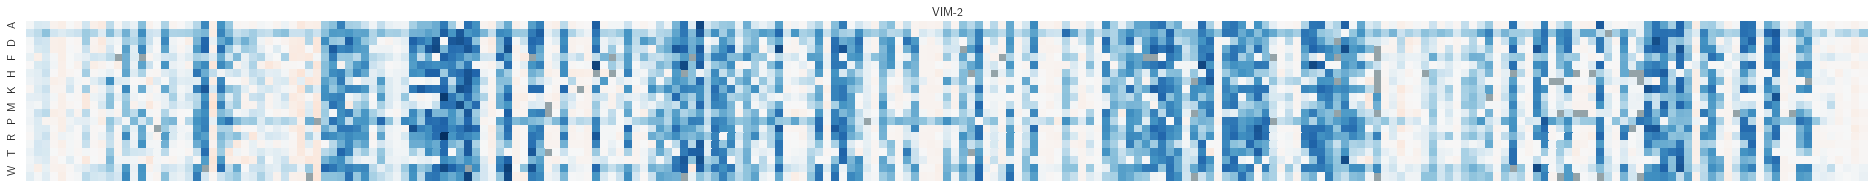

In [36]:
PlotHeatmap(func, save_as='figures/heatmap_func', title='VIM-2', vmin=None, vmax=None, reverse=False)
#PlotHeatmap(func, vmin=None, vmax=None, reverse=False)

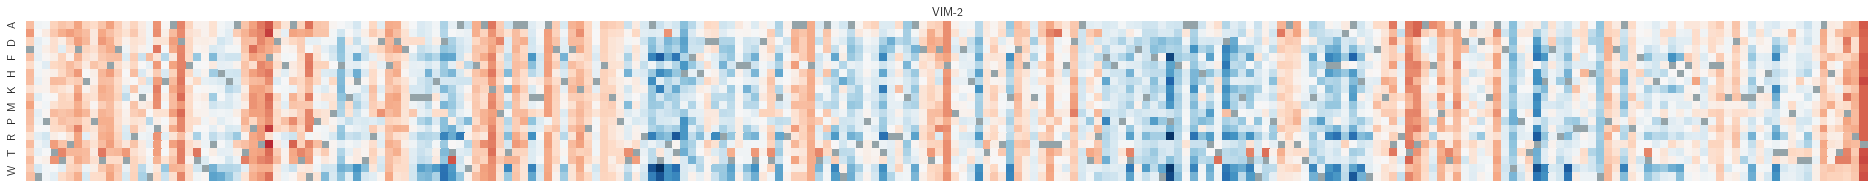

In [37]:
PlotHeatmap(struc, save_as='figures/heatmap_struc', title='VIM-2', vmin=None, vmax=None, reverse=True)
#PlotHeatmap(struc, vmin=None, vmax=None, reverse=True, save_as="loss_heatmap_")

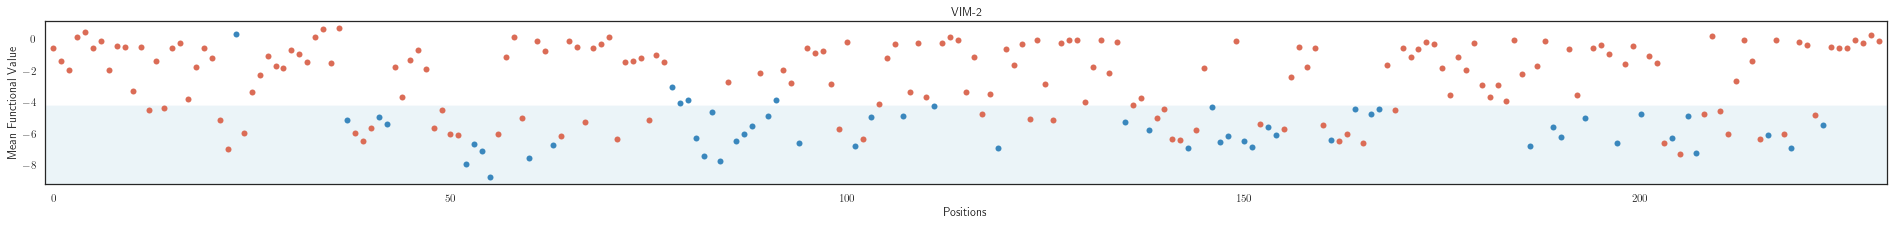

In [24]:
# accuracy
X = GraphLossPredictions(0.4, 4, measure_cutoffs=[1.5,1.5,1.5,1.5], proteins=[proteins[-1]])
X.savefig("figures/accuracy_loss_1.png", bbox_inches='tight', dpi=300)

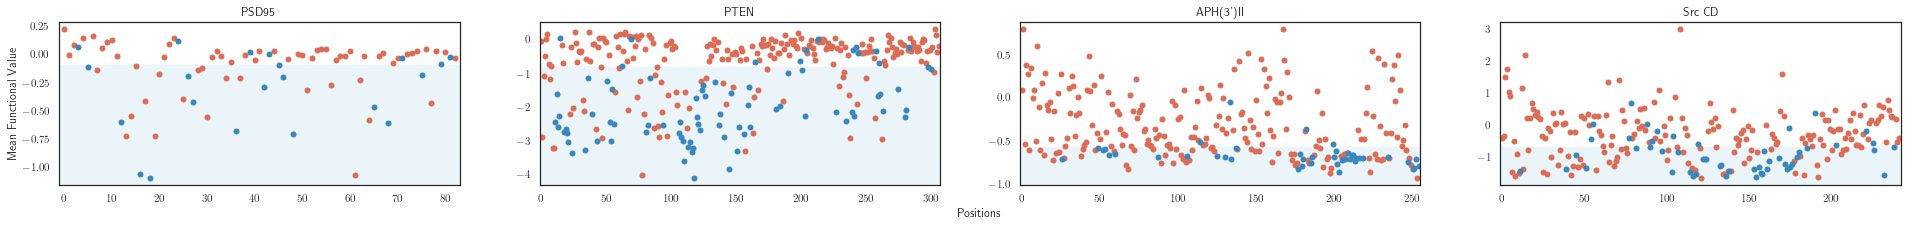

In [25]:
# accuracy
Y = GraphLossPredictions(0.4, 4, measure_cutoffs=[1.5,1.5,1.5,1.5], proteins=proteins[:-1])
Y.savefig("figures/accuracy_loss_2.png", bbox_inches='tight', dpi=300)

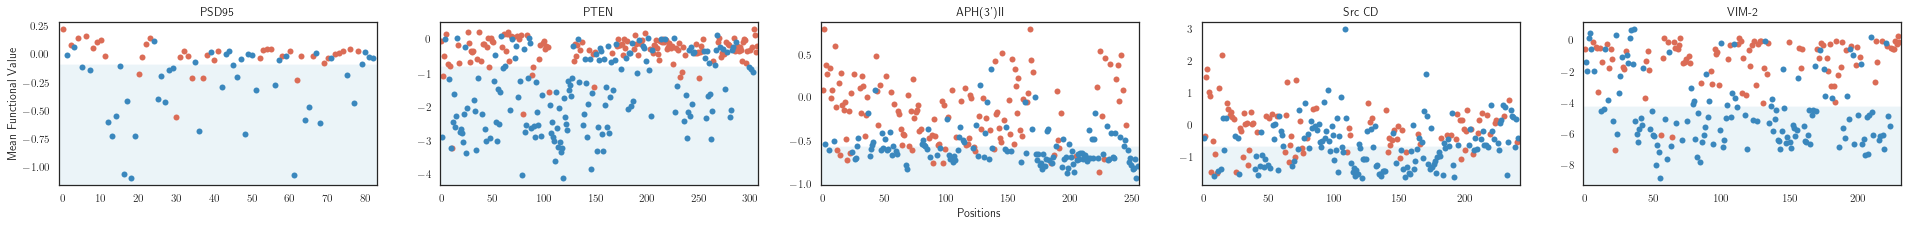

In [26]:
# coverage
Z = GraphLossPredictions(0.4, 2, measure_cutoffs=[1,1,1,1])
Z.savefig("figures/coverage_loss.png", bbox_inches='tight', dpi=300)

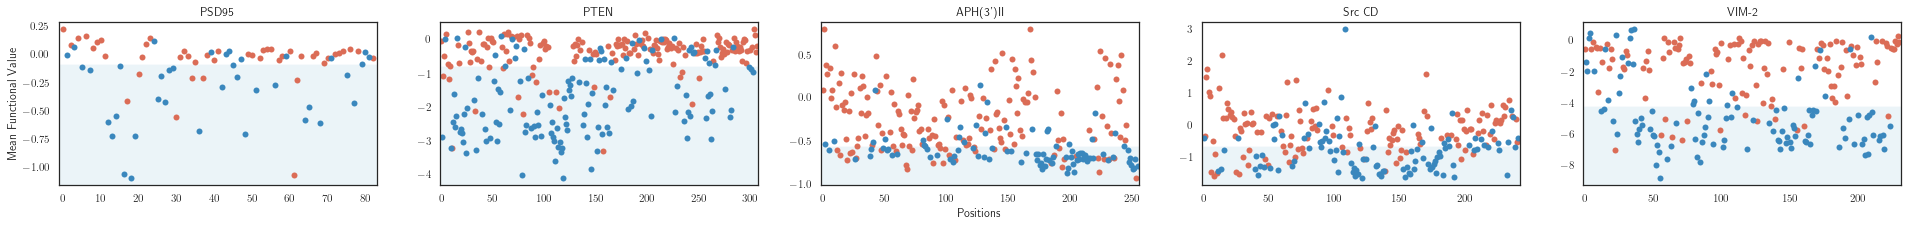

In [27]:
# both
A = GraphLossPredictions(0.4, 2, measure_cutoffs=[1.5,1.5,1.5,1.5])
A.savefig("figures/both_loss.png", bbox_inches='tight', dpi=300)

In [28]:
# width = 345
# fig, ax = plt.subplots(1, 1, figsize=set_size(width, fraction=1))
# ax.axis('on')

# sns.heatmap(func, cmap='RdBu_r', center=0, cbar=False, xticklabels=False,
#            yticklabels=True, ax=ax);
# ax.tick_params(axis='y', labelsize=5)
# fig.savefig('figures/heatmap_func.png', dpi=300)

### Robustness 

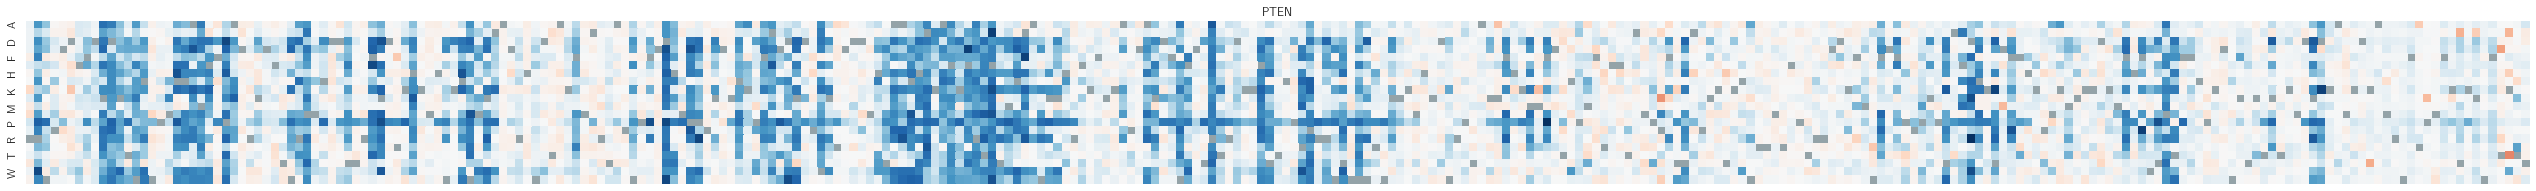

In [38]:
# lighter areas represent functional values closer to 0
PlotHeatmap(functional_data['1d5r'], save_as="figures/heatmap_func_gain",title='PTEN', reverse=False)

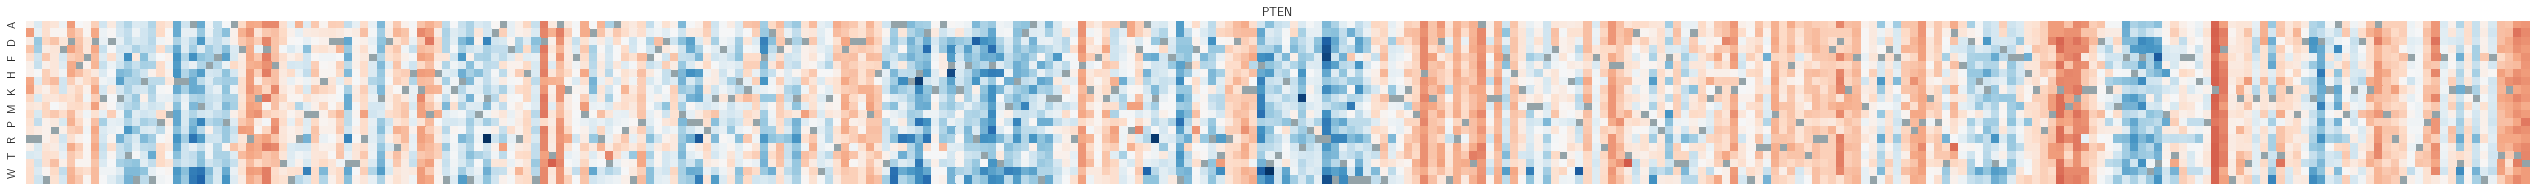

In [39]:
PlotHeatmap(Standardize('1d5r', 9.0, 'nodes'), save_as="figures/heatmap_struc_gain", title='PTEN', reverse=True)

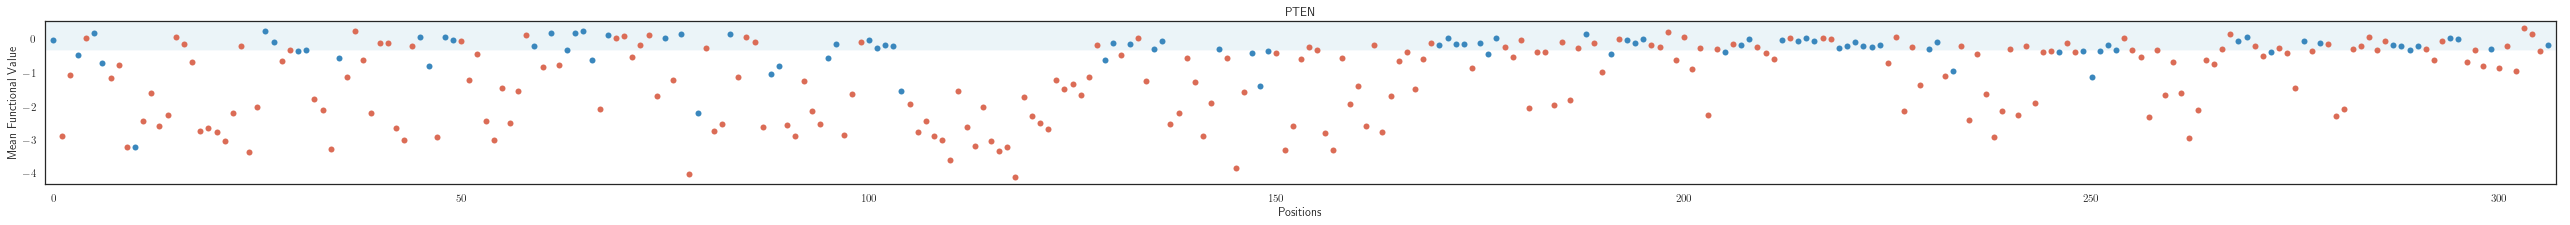

In [44]:
# accuracy
X = GraphGainPredictions(0.4, 1, measure_cutoffs=[1,1,1,1], proteins=[proteins[1]])
X.savefig("figures/accuracy_gain_1.png", bbox_inches='tight', dpi=300)

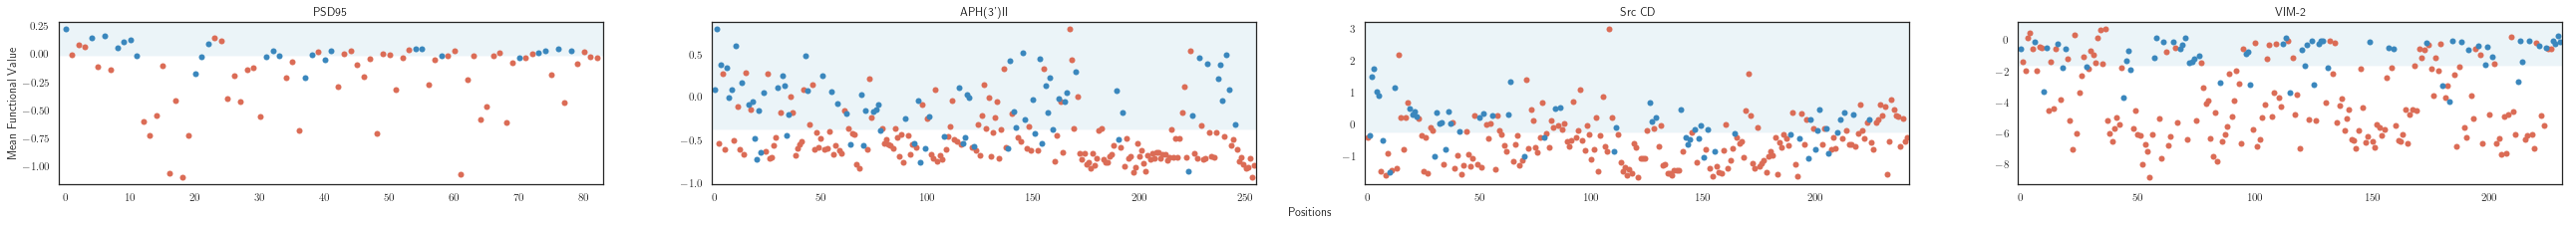

In [45]:
# accuracy
Y = GraphGainPredictions(0.4, 1, measure_cutoffs=[1,1,1,1], proteins=[proteins[0]]+proteins[2:])
Y.savefig("figures/accuracy_gain_2.png", bbox_inches='tight', dpi=300)

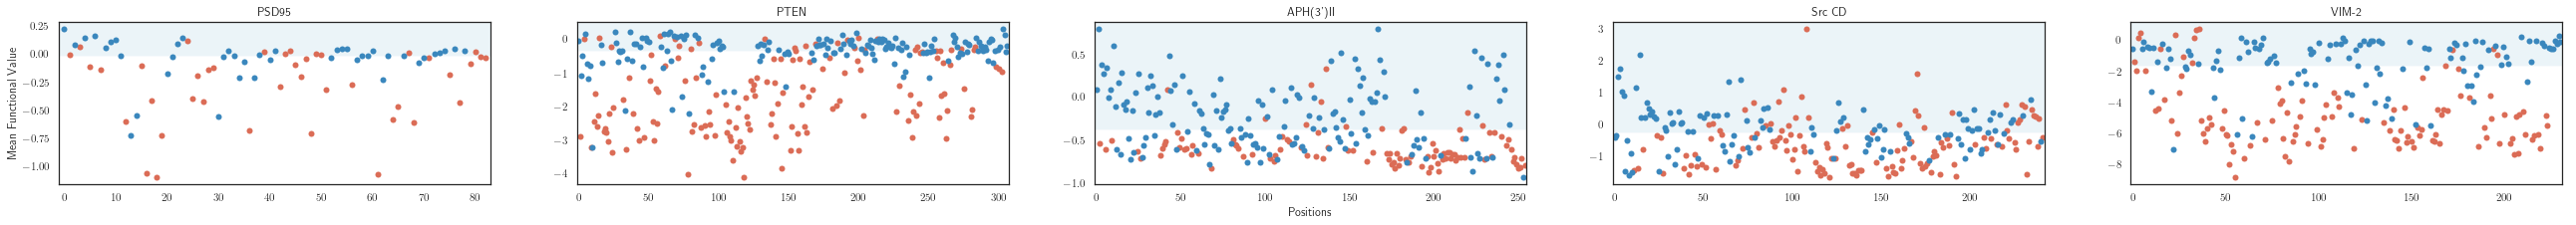

In [46]:
# coverage
Z = GraphGainPredictions(0.4, 3, measure_cutoffs=[1,1,1,1])
Z.savefig("figures/coverage_gain.png", bbox_inches='tight', dpi=300)

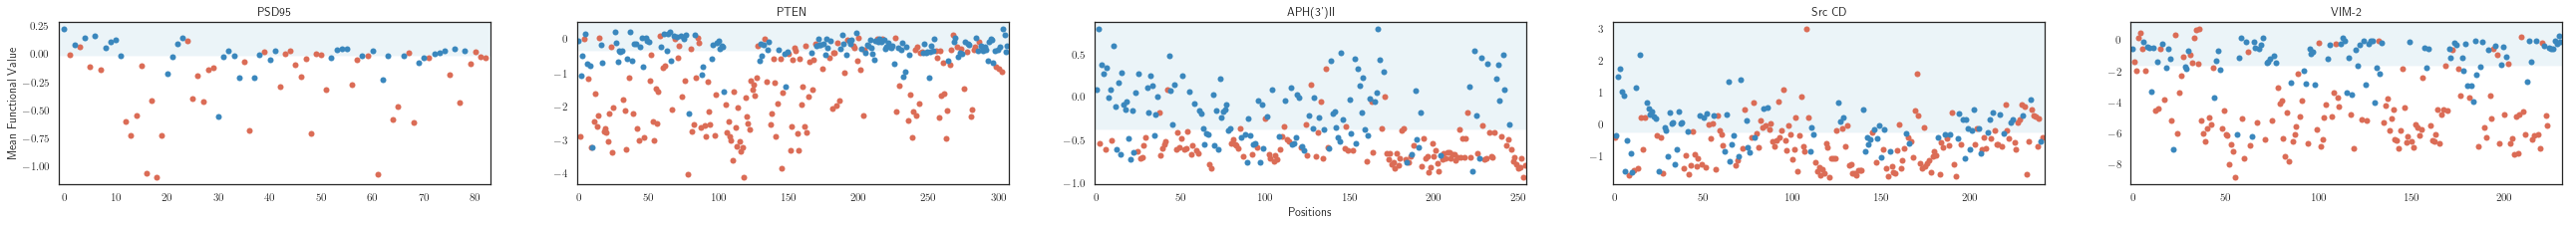

In [47]:
# both
A = GraphGainPredictions(0.4, 2, measure_cutoffs=[1,1,1,1])
A.savefig("figures/both_gain.png", bbox_inches='tight', dpi=300)